# Pet and Family Identifier v1

The main idea is create a identifier of the pets in my family by photos.

In [1]:
from pathlib import Path
import wandb
from fastai.callback.wandb import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import pandas as pd
set_seed(7)
# %matplotlib inline
%config IPCompleter.greedy=True

Settup WB

In [2]:
wandb.init(project='pet and  identifier')

wandb: Currently logged in as: j-martin (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.21 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Load photos

Load photos with pets and people, one upgrade could be using segmentation to place the label in the image.

In [3]:
path = Path().cwd()/"photos"
df = pd.read_csv(path/'photos.csv')

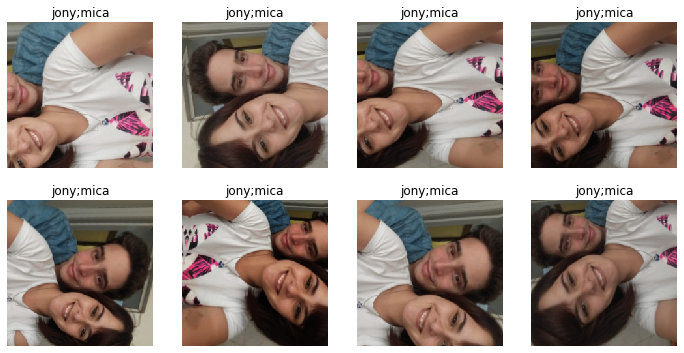

In [5]:
def petandfamilyidentifier_get_x(r): return path/r['fname']#Named "petandfamilyidentifier_*" because the reference is saved with the learner and to avoid collisions.
def petandfamilyidentifier_get_y(r): return r['labels'].split(' ')
pets = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock), 
    get_x=petandfamilyidentifier_get_x, 
    get_y=petandfamilyidentifier_get_y,
    splitter=RandomSplitter(valid_pct=0.2, seed=7),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pets.dataloaders(df,num_workers=0)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Create a model

In [6]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2),cbs=WandbCallback()) 

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.009120108559727669)

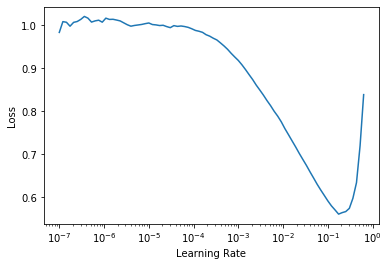

In [7]:
learn.lr_find()

In [8]:
learn.fine_tune(4, base_lr=3e-2, freeze_epochs=4)

WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.814760,1.820858,0.425000,00:43
1,0.613452,0.900821,0.664583,00:46
2,0.481441,0.410998,0.854167,00:47
3,0.386686,0.216732,0.937500,00:46


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.093404,0.802480,0.812500,00:45
1,0.127880,1.192923,0.820833,00:47
2,0.133896,0.474075,0.918750,00:45
3,0.115092,0.320602,0.927083,00:48


## Evaluate

Creation of confusion matrix.

In [9]:
interp = ClassificationInterpretation.from_learner(learn)

See the top losses.

,target,predicted,probabilities,loss
0,nina,sol,"tensor([3.5792e-05, 2.4144e-06, 3.6790e-03, 7.8923e-06, 4.2434e-04, 1.0000e+00])",3.8727169036865234
1,nina,sol,"tensor([1.7909e-07, 1.6703e-05, 1.8011e-04, 1.2233e-04, 1.1483e-03, 1.0000e+00])",3.260305404663086
2,sol,mica;sol,"tensor([1.6708e-07, 1.8350e-07, 1.0000e+00, 1.8651e-03, 6.8005e-06, 1.0000e+00])",2.3168230056762695
3,mica,jony;mica,"tensor([1.8121e-04, 9.9992e-01, 9.5942e-01, 6.1725e-04, 2.5425e-04, 1.2593e-03])",1.5717825889587402
4,mica,jony;mica,"tensor([1.3920e-04, 9.9989e-01, 9.9997e-01, 9.8549e-03, 3.6824e-05, 1.0583e-02])",1.5295641422271729


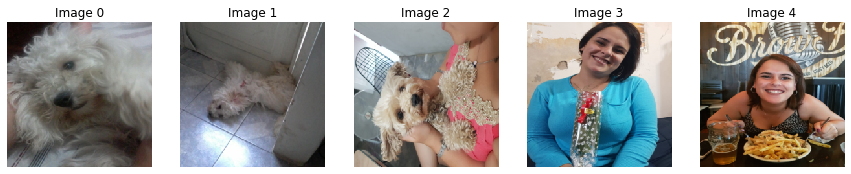

In [10]:
interp.plot_top_losses(5, nrows=1)

###  Export model

In [11]:
learn.export("petandfamilyidentifier_windows.pkl")

## Predict

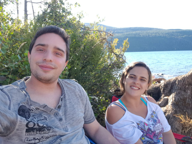

(['jony'], tensor([False,  True, False, False, False, False]), tensor([5.5598e-05, 1.0000e+00, 2.5613e-01, 9.6289e-06, 5.6978e-04, 1.2747e-03]))


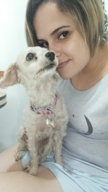

(['mica', 'sol'], tensor([False, False,  True, False, False,  True]), tensor([1.3969e-04, 9.7771e-04, 1.0000e+00, 2.4852e-02, 1.0597e-03, 5.7873e-01]))


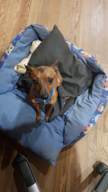

(['nexus'], tensor([False, False, False,  True, False, False]), tensor([2.1447e-07, 5.1915e-02, 4.8717e-09, 1.0000e+00, 2.0267e-04, 1.9921e-06]))


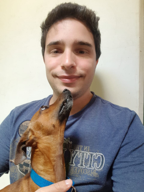

(['jony'], tensor([False,  True, False, False, False, False]), tensor([3.4798e-05, 9.9998e-01, 5.2649e-03, 6.3654e-02, 1.3685e-04, 5.7739e-04]))


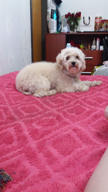

(['mica', 'nina', 'sol'], tensor([False, False,  True, False,  True,  True]), tensor([1.3531e-06, 2.2411e-05, 9.9944e-01, 7.6963e-03, 9.8423e-01, 8.1676e-01]))


In [12]:
for p in Path().cwd().glob("*.jp*"):
    image_to_pred = p
    img = PILImage.create(image_to_pred)
    display(img.to_thumb(192))
    print(learn.predict(image_to_pred))